# Introduction to 🤗 Diffusers

![diffusers_library](https://github.com/huggingface/diffusers/raw/main/docs/source/imgs/diffusers_library.jpg)

在这个notebook里，你将训练你的第一个扩散模型来**生成美丽的蝴蝶的图片 🦋.** 在此过程中，您将了解🤗 Diffuers库，它将为我们稍后将在课程中介绍的更高级的应用程序提供良好的基础

让我们开始吧！

## 你将学习到

在这个notebook中，你将:

- 看到一个强大的自定义扩散模型管道 (并了解到如何制作一个自己的版本)
- 通过以下方式创建您自己的迷你管道:
  - 回顾扩散模型背后的核心思想
  - 从hub中加载数据进行培训
  - 探索如何使用scheduler将噪声添加到数据中
  - 创建和训练一个UNet模型
  - 将各个组件拼装在一起来形成一个工作管道(working pipelines)
- 编辑并运行一个脚本，用于初始化一个较长的训练，该脚本将处理
  - 使用Accelerate来进行多GPU加速训练
  - 实验日志记录以跟踪关键统计数据
  - 将最终的模型上传到 Hugging Face Hub

❓如果您有任何问题，请发布在Hugging Face的Discord服务器 `#diffusion-models-class`频道中. 你可以在这里完成注册: https://huggingface.co/join/discord

## 预备知识

在进入notebook之前，你需要:

* 📖 阅读第一单元的材料
* 🤗在Hugging Face Hub上创建一个账户. 你可以在这里完成注册: https://huggingface.co/join

## 步骤 1: 设置

运行以下单元以安装diffusers库以及一些其他要求：

In [ ]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow

接下来，请前往 https://huggingface.co/settings/tokens 创建具有写权限的访问令牌：

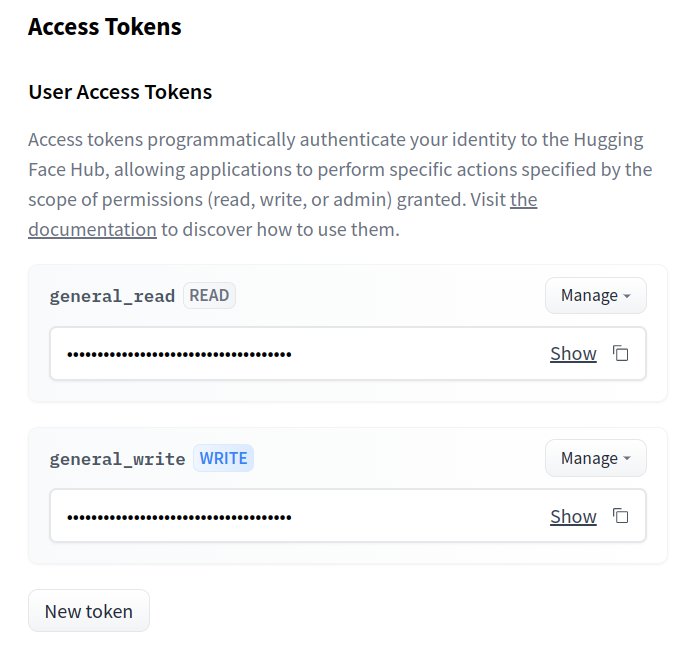

您可以使用命令行来通过此令牌登录(`huggingface-cli login`)或者运行以下单元来登录：

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


然后您需要安装Git LFS来上传模型检查点：

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

最后，让我们导入将要使用的库，并定义一些方便函数，稍后我们将会在notebook中使用这些函数：

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

好了，我们都准备好了！

## Dreambooth：即将到来的巅峰

如果你在过去几个月里看过人工智能相关的社交媒体，你就会听说过Stable Diffusion模型。这是一个强大的文本条件隐式扩散模型（别担心，我们将会学习这些概念）。但它有一个缺点：它不知道你或我长什么样，除非我们足够出名以至于互联网上发布我们的照片。

Dreambooth允许我们创建自己的模型变体，并对特定的面部、对象或样式有一些额外的了解。Corridor Crew制作了一段出色的视频，用一致的任务形象来讲故事，这是一个很好的说明了这种技术的能力的例子：

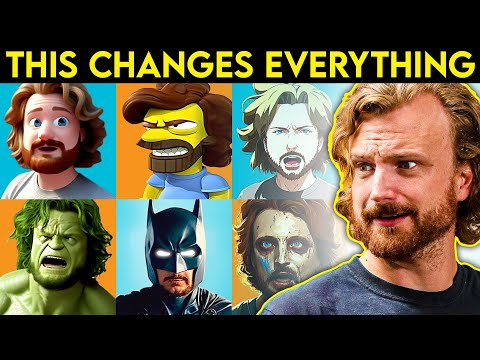

In [3]:
from IPython.display import YouTubeVideo

YouTubeVideo("W4Mcuh38wyM")

这是一个使用了[这个模型](https://huggingface.co/sd-dreambooth-library/mr-potato-head)的例子。该模型的训练使用了5张著名的儿童玩具"Mr Potato Head"的照片。

首先，让我们来加载这个管道。这些代码会自动从Hub下载模型权重等需要的文件。由于这个只有一行的demo需要下载数GB的数据，因此您可以跳过此单元格，只需欣赏样例输出即可！

In [4]:
from diffusers import StableDiffusionPipeline

# Check out https://huggingface.co/sd-dreambooth-library for loads of models from the community
model_id = "sd-dreambooth-library/mr-potato-head"

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    device
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

管道加载完成后，我们可以使用以下命令生成图像：

  0%|          | 0/51 [00:00<?, ?it/s]

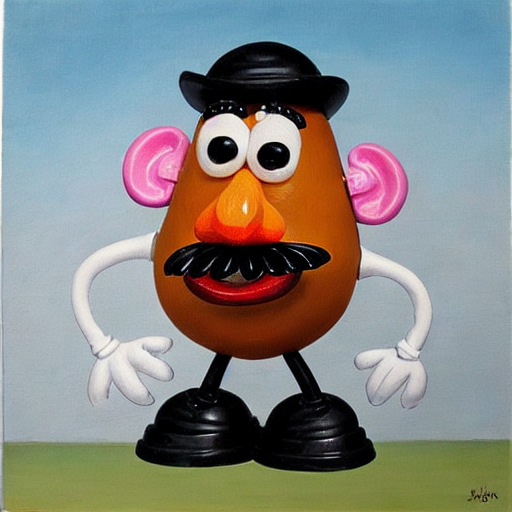

In [5]:
prompt = "an abstract oil painting of sks mr potato head by picasso"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

**练习:** 您可以使用不同的提示(prompt)自行尝试。在这个demo中， `sks` 是一个新概念的唯一标识符(UID) - 那么如果把它留空的话会发生什么事呢? 您还可以尝试改变`num_inference_steps`和 `guidance_scale`。这两个参数分别代表了采样步骤的数量（试试最多可以设为多低？）和模型将花多大的努力来尝试匹配提示。

这条神奇的管道里有很多事情！课程结束时，你将知道这一切是如何运作的。现在，让我们看看如何从头开始训练扩散模型。

## MVP (最简可实行管道)
🤗 Diffusers 的核心API被分为三个主要部分:
1. **管道**: 从高层出发设计的多种类函数，旨在以易部署的方式，能够做到快速通过主流预训练好的扩散模型来生成样本。
2. **模型**: 训练新的扩散模型时用到的主流网络架构, *e.g.* [UNet](https://arxiv.org/abs/1505.04597).
3. **管理器(or调度器)**: 在*推理*中使用多种不同的技巧来从噪声中生成图像，同时也可以生成在*训练*中所需的带噪图像。

管道对于末端使用者来说已经非常棒，但你既然已经参加了这门课程，我们就索性认为你想了解更多其中的奥秘！在此篇笔记结束之后，我们会来构建属于你自己，能够生成小蝴蝶图片的管道。下面这里会是最终的结果：

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

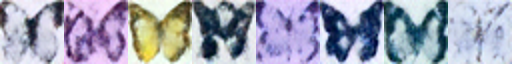

In [6]:
from diffusers import DDPMPipeline

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)

In [ ]:
也许这看起来并不如DreamBooth所展示的样例那样惊艳，但要知道我们在训练这些图画时只用了不到训练稳定扩散模型用到数据的0.0001%。说到模型训练，从引入介绍直到本单元，训练一个扩散模型的流程看起来像是这样：

1.   从训练集中加载一些图像
2.   加入噪声，从不同程度上
3.   把带了不同版本噪声的数据送进模型
4.   评估模型在对这些数据做增强去噪时的表现
5.   使用这个信息来更新模型权重，然后重复此步骤

我们会在接下来几节中逐一实现这些步骤，直至训练循环可以完整的运行，在这之后我们会来探索如何使用训练好的模型来生成样本，还有如何封装模型到管道中来轻松的分享给别人。下面我们来从数据入手吧。。。

## 步骤 2：下载一个训练数据集

在这个例子中,我们会用到一个来自Hugging Face Hub的图像集。具体来说, [是个1000张蝴蝶图像收藏集](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset). 这是个非常小的数据集, 我们这里也同时包含了已被注释的内容指向一些规模更大的选择。如果你想使用你自己的图像收藏，你也可以使用这里被注释掉的示例代码，从一个指定的文件夹来装载图片。

In [ ]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

我们可以从中取出一批图像数据来看一看他们是什么样子:

X shape: torch.Size([8, 3, 32, 32])


/tmp/ipykernel_4278/3975082613.py:3: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)


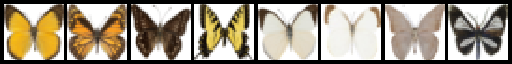

In [3]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

我们在此篇笔记中使用一个只有32像素的小图片集来保证训练时长是可控的。

## 步骤 3：定义管理器

我们的训练计划是，取出这些输入图片然后对它们增添噪声，在这之后把带噪的图片送入模型。在推理阶段，我们将用模型的预测值来不断迭代去除这些噪点。在`diffusers`中，这两个步骤都是由**管理器（调度器）**来处理的。

噪声管理器决定在不同的迭代周期时分别加入多少噪声。我们可以这样创建一个管理器，是取自于训练并能取样 'DDPM'的默认配置。 (基于此篇论文 ["Denoising Diffusion Probabalistic Models"](https://arxiv.org/abs/2006.11239):

In [3]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

DDPM论文这样来描述一个损坏过程，为每一个 '迭代周期'(timestep)增添一点少量的噪声。设在某个迭代周期有 $x_{t-1}$, 我们可以得到它的下一个版本 $x_t$ （比之前更多一点点噪声）:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


这就是说，我们取 $x_{t-1}$, 给他一个$\sqrt{1 - \beta_t}$ 的系数，然后加上带有 $\beta_t$系数的噪声。 这里 $\beta$ 是根据一些管理器来为每一个t设定的，来决定每一个迭代周期中添加多少噪声。 现在，我们不想把这个推演进行500次来得到 $x_{500}$，所以我们用另一个公式来根据给出的 $x_0$ 计算得到任意t时刻的 $x_t$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

数学符号看起来总是很可怕！好在有管理器来为我们完成这些运算。我们可以画出 $\sqrt{\bar{\alpha}_t}$ (标记为 `sqrt_alpha_prod`) 和 $\sqrt{(1 - \bar{\alpha}_t)}$ (标记为 `sqrt_one_minus_alpha_prod`) 来看一下输入(x)与噪声是如何在不同迭代周期中量化和叠加的:

In [ ]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

**练习:** 你可以探索一下使用不同的beta_start时曲线是如何变化的，beta_end 与 beta_schedule可以通过以下注释内容来修改:

In [10]:
# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

不论你选择了哪一个管理器(调度器)，我们现在都可以使用 `noise_scheduler.add_noise`功能来添加不同程度的噪声，就像这样：

Noisy X shape torch.Size([8, 3, 32, 32])


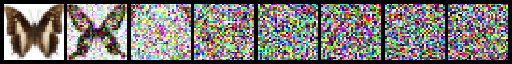

In [11]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

再来，在这里探索使用这里不同噪声管理器和预设参数带来的效果。 [This video](https://www.youtube.com/watch?v=fbLgFrlTnGU) 这个视频很好的解释了一些上述数学运算的细节，同时也是对此类概念的一个很好引入介绍。

## 步骤 4：定义模型

现在我们来到了核心部分：模型本身。 

大多数扩散模型使用的模型结构都是一些[U-net]的变形(https://arxiv.org/abs/1505.04597) 也是我们在这里会用到的结构。

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

概括来说:
- 输入模型中的图片经过几个由ResNetLayer构成的层，其中每层都使图片尺寸减半。
- 之后在经过同样数量的层把图片升采样。
- 其中还有对特征在相同位置的上、下采样层残差连接模块。

模型一个关键特征既是，输出图片尺寸与输入图片相同，这正是我们这里需要的。

Diffusers 为我们提供了一个易用的 `UNet2DModel` 类，用来在PyTorch创建所需要的结构。

我们来使用U-net为我们生成目标大小的图片吧。
注意这里 `down_block_types` 对应下采样模块 (上图中绿色部分), 而 `up_block_types` 对应上采样模块 (上图中红色部分):

In [ ]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

当在处理更高分辨率的输入时，你可能想用更多层的下、上采样模块，让注意力层只聚焦在最低分辨率（最底）层来减少内存消耗。我们在之后会讨论该如何实验来找到最适用与你手头场景的配置方法。

我们可以通过输入一批数据和随机的迭代周期数来看输出是否与输入尺寸相同：

In [13]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

在下一步中，我们来看如何训练这个模型。

## 步骤 5：创建训练循环

终于可以训练了！下面这是PyTorch中经典的优化迭代循环，在这里一批一批的送入数据然后通过优化器来一步步更新模型参数 - 在这个样例中我们使用学习率为0.0004的AdamW优化器。 

对于每一批的数据，我们要
- 随机取样几个迭代周期
- 根据预设为数据加入噪声
- 把带噪数据送入模型
- 使用MSE作为损失函数来比较目标结果与模型预测结果（在这里是加入噪声的场景）
- 通过 `loss.backward()` 与 `optimizer.step()`来更新模型参数

在这个过程中我们记录Loss值用来后续的绘图。

NB: 这段代码大概需10分钟来运行 - 你也可以跳过以下两块操作直接使用预训练好的模型。供你选择，你可以探索下通过缩小模型层中的通道数会对运行速度有多少提升。

官方扩散模型示例 [official diffusers training example](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb) 训练了在更高分辨率数据集上的一个更大的模型，这也是一个极为精简训练循环的优秀示例：

In [14]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:5, loss: 0.16273280512541533
Epoch:10, loss: 0.11161588924005628
Epoch:15, loss: 0.10206522420048714
Epoch:20, loss: 0.08302505919709802
Epoch:25, loss: 0.07805309211835265
Epoch:30, loss: 0.07474562455900013


绘制loss曲线，我们能看到模型在一开始快速的收敛，接下来以一个较慢的速度持续优化（我们用右边log坐标轴的视图可以看的更清楚）：

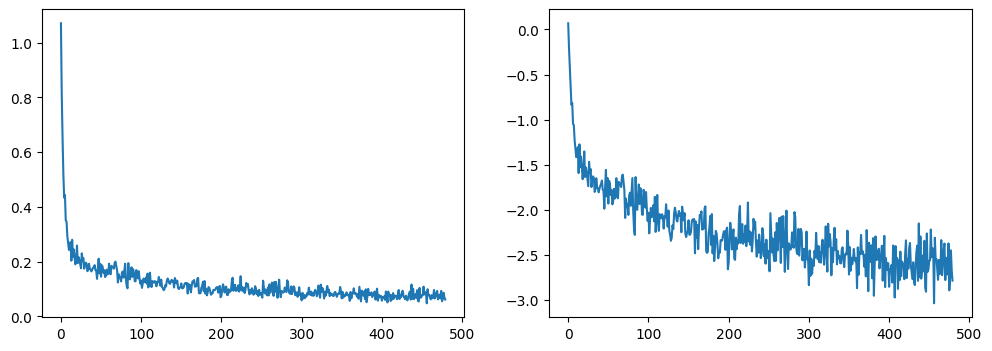

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

你可以选择运行上面的代码，也可以这样通过管道来调用模型：

In [ ]:
# Uncomment to instead load the model I trained earlier:
# model = butterfly_pipeline.unet

## 步骤 6：生成图像

我们怎么从这个模型中得到图像呢？

### 方法 1：建立一个管道：

In [16]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

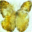

In [17]:
pipeline_output = image_pipe()
pipeline_output.images[0]

我们可以在本地文件夹这样保存一个管道：

In [18]:
image_pipe.save_pretrained("my_pipeline")

检查文件夹的内容：

In [ ]:
!ls my_pipeline/

model_index.json  scheduler  unet


这里 `scheduler` 与 `unet` 子文件夹中包含了生成图像所需的全部组件。比如，在 `unet` 文件中能看到模型参数(`diffusion_pytorch_model.bin`) 与描述模型结构的配置文件。

In [ ]:
!ls my_pipeline/unet/

config.json  diffusion_pytorch_model.bin


以上，这些文件包含了重新建立一个管道的全部内容。你可以手动把它们上传到hub来与他人分享你制作的管道，或使用下一节的API方法来记载。

### 方法 2：写一个取样循环
如果你去查看了管道中的forward方法，你可以看到在运行 `image_pipe()`时发生了什么：

In [ ]:
# ??image_pipe.forward

从随机噪声开始，遍历管理器的迭代周期来看从最嘈杂直到最微小的噪声变化，基于模型的预测一步步减少一些噪声：

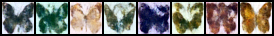

In [20]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

 `noise_scheduler.step()` 函数相应做了 `sample`（取样）时的数学运算。其实有很多取样的方法 - 在下一个单元我们将看到在已有模型的基础上如何换一个不同的取样器来加速图片生成，也会讲到更多从扩散模型中取样的背后原理。

## 步骤 7：把你的模型Push到Hub

在上面的例子中我们把管道保存在了本地。把模型push到hub上，我们会需要建立模型和相应文件的仓库名。我们根据你的选择（模型ID）来决定仓库的名字（大胆的去替换掉 `model_name`吧；需要包含你的用户名，`get_full_repo_name()`会帮你做到）：

In [1]:
from huggingface_hub import get_full_repo_name

model_name = "sd-class-butterflies-32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'lewtun/sd-class-butterflies-32'

然后，在 🤗 Hub上创建模型仓库并push它吧：

In [22]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

'https://huggingface.co/lewtun/sd-class-butterflies-32/blob/main/model_index.json'

最后一件事是创建一个超棒的模型卡，如此，我们的蝴蝶生成器可以轻松的在Hub上被找到（请在描述中随意发挥！）：

In [ ]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

现在模型已经在Hub上了，你可以这样从任何地方使用 `DDPMPipeline`的 `from_pretrained()`方法来下来它：

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

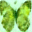

In [24]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]

太棒了，成功了！

# 使用🤗 Accelerate来扩大规模 

这篇笔记是用来教学，为此我尽力保证代码的简洁与轻量化。但也因为这样，我们也略去了一些内容你也许在使用更多数据训练一个更大的模式时，可能所需要用到的内容，如多块GPU支持，进度记录和样例图片，用于支持更大batchsize的导数记录功能，自动上传模型等等。好在这些功能大多数在这个示例代码中包含 [here](https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py).

你可以这样下载该文件：

In [ ]:
!wget https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py

打开文件，你就可以看到模型是怎么定义的，以及有哪些可选的配置参数。我使用如下命令运行了该代码：

In [8]:
# Let's give our new model a name for the Hub
model_name = "sd-class-butterflies-64"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'lewtun/sd-class-butterflies-64'

In [ ]:
!accelerate launch train_unconditional.py \
  --dataset_name="huggan/smithsonian_butterflies_subset" \
  --resolution=64 \
  --output_dir={model_name} \
  --train_batch_size=32 \
  --num_epochs=50 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_warmup_steps=500 \
  --mixed_precision="no"

如之前一样，把模型push到hub，并且创建一个超酷的模型卡（按你的想法随意填写！）：

In [14]:
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{model_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{model_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{model_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/lewtun/sd-class-butterflies-64/blob/main/README.md'

大概45分钟之后，得到这样的结果：

  0%|          | 0/1000 [00:00<?, ?it/s]

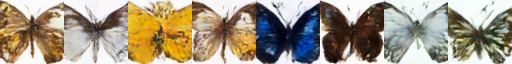

In [5]:
pipeline = DDPMPipeline.from_pretrained(hub_model_id).to(device)
images = pipeline(batch_size=8).images
make_grid(images)

**练习:** 看看你能不能找到训练出在短时内能得到满意结果的模型训练设置参数，并与社群分享你的发现。阅读这些脚本看看你能不能理解它们，如果遇到了一些看上去令人迷惑的地方，请向大家提问来寻求解释。

# 更高阶的探索之路

希望这些能够让你初步了解可以使用 🤗 Diffusers library来做什么！可能一些后续的步骤是这样：

- 尝试在新数据集上训练一个无限制的扩散模型 - 如果你能直接自己完成那就太好了 [create one yourself](https://huggingface.co/docs/datasets/image_dataset). 你可以在Hub这里找到一些能完成这个任务的超棒图像数据集 [HugGan organization](https://huggingface.co/huggan). 如果你不想等待模型训练太久的话，一定记得对图片做下采样！
- 试试用DreamBooth来创建你自己定制的扩散模型管道，看看这里 [this Space](https://huggingface.co/spaces/multimodalart/dreambooth-training) 或者 [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb)
- 修改训练脚本来探索使用不同的UNet超参数（层数深度，通道数等等），不同的噪声管理器等等。
- 来瞧瞧 [Diffusion Models from Scratch](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb) 在本单元的核心思想之上的一些不同看法。

祝好，敬请关注第2单元！